In [179]:
#Importação das bibiliotecas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import numpy as np
import re
import textstat
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
###
from sklearn.preprocessing import LabelEncoder 
from sklearn.utils import resample 
from keras.preprocessing.text import Tokenizer 
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout, SpatialDropout1D
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ADM\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ADM\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ADM\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [139]:
#Importação dos dados
data = pd.read_csv ('data.csv')

In [140]:
#Vizualização do Dataset
display(data)

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
...,...,...
5837,RISING costs have forced packaging producer Hu...,negative
5838,Nordic Walking was first used as a summer trai...,neutral
5839,"According shipping company Viking Line , the E...",neutral
5840,"In the building and home improvement trade , s...",neutral


**Análise Exploratória dos Dados**

In [141]:
#Obtendo informações sobre o dataset.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [142]:
#Verificando qual a distribuição.
data['Sentiment'].value_counts()


neutral     3130
positive    1852
negative     860
Name: Sentiment, dtype: int64

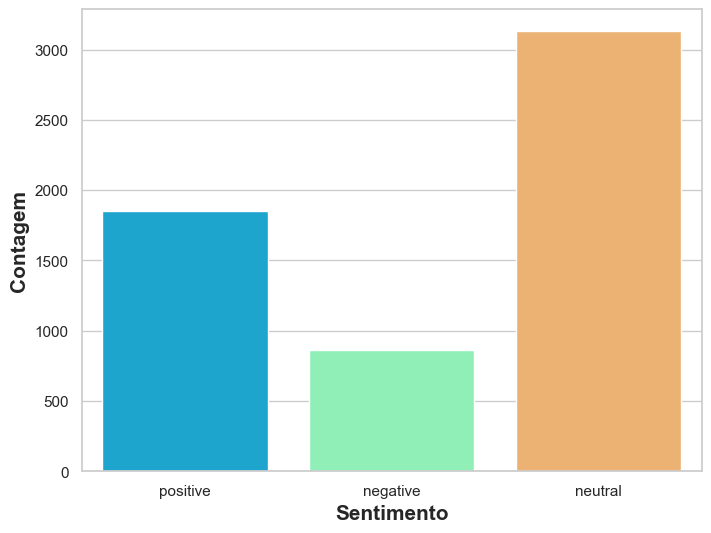

In [117]:
#Verificando a distribuição de forma gráfica
plt.figure(figsize=(8,6))
sns.countplot(x = 'Sentiment',data=data,palette ='rainbow')
plt.xlabel("Sentimento",fontweight='bold',size=15)
plt.ylabel("Contagem",fontweight='bold',size=15)
plt.show()

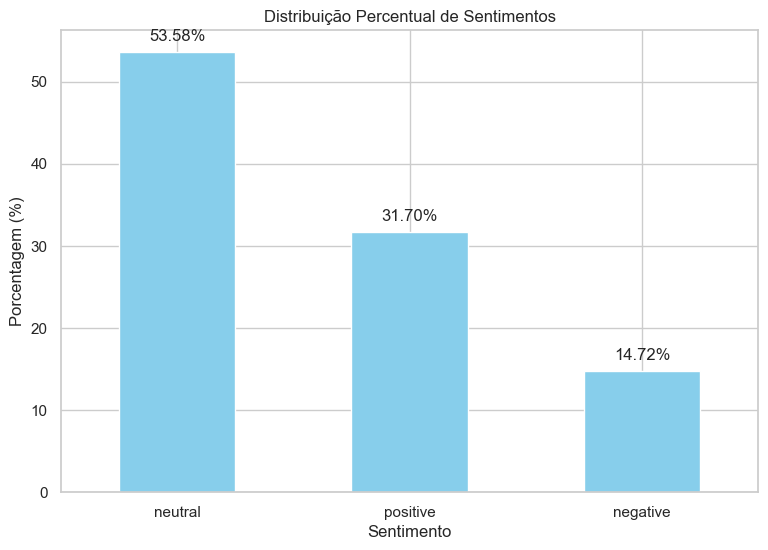

In [143]:
# Calculando a distribuição de maneira percentual
contagem = data['Sentiment'].value_counts()
x = (contagem / len(data)) * 100
plt.figure(figsize=(9, 6))
x.plot(kind='bar', color='skyblue')
plt.title("Distribuição Percentual de Sentimentos")
plt.xlabel("Sentimento")
plt.ylabel("Porcentagem (%)")
for index, value in enumerate(x):
    plt.text(index, value + 1, f'{value:.2f}%', ha='center', va='bottom', fontsize=12)

plt.xticks(rotation=0)
plt.show()

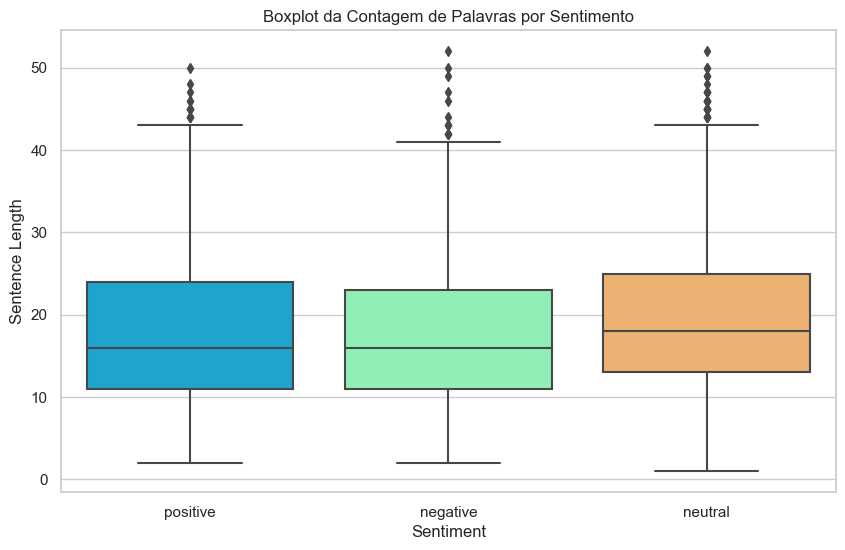

In [146]:
#Criando um Boxplot para a quantidade de palavras por sentimento
data['Sentence Length'] = data['Sentence'].apply(lambda x: textstat.lexicon_count(x, removepunct=True))
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.boxplot(x='Sentiment', y='Sentence Length', data=data, palette="rainbow")
plt.title("Boxplot da Contagem de Palavras por Sentimento")
plt.show()


In [147]:
# Exibir as estatísticas descritivas de cada sentença
agr = data.groupby('Sentiment')
agr1 = agr['Sentence Length'].describe()
print(agr1)

            count       mean       std  min   25%   50%   75%   max
Sentiment                                                          
negative    860.0  17.590698  8.944527  2.0  11.0  16.0  23.0  52.0
neutral    3130.0  19.655272  8.795519  1.0  13.0  18.0  25.0  52.0
positive   1852.0  18.089633  9.190085  2.0  11.0  16.0  24.0  50.0


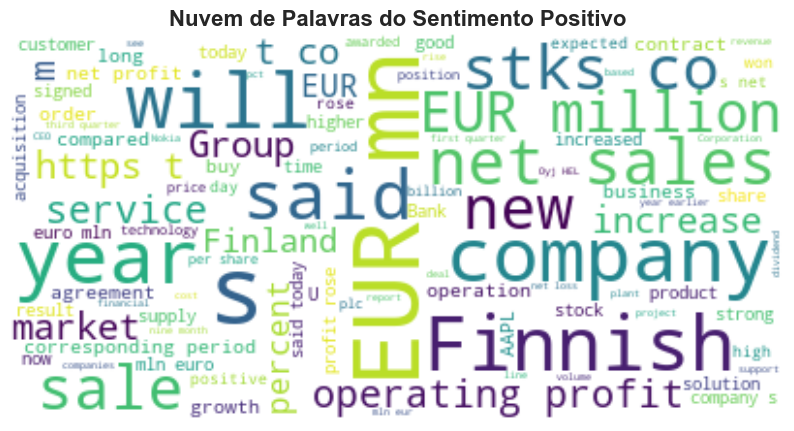

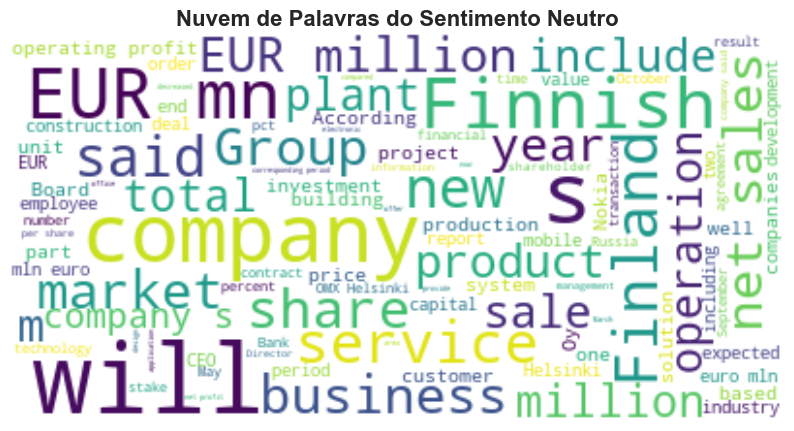

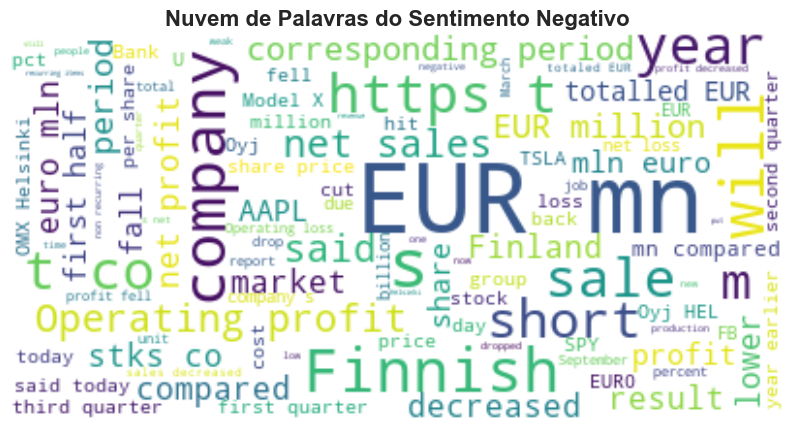

In [148]:
# Criando uma nuvem de palavras para exibir as palavras mais utilizadas em cada categoria de sentimento.

textos_positivos = data['Sentence'][data['Sentiment'] == 'positive']
textos_neutros = data['Sentence'][data['Sentiment'] == 'neutral']
textos_negativos = data['Sentence'][data['Sentiment'] == 'negative']

def tokenizador(texto):
    tokens = nltk.word_tokenize(texto)
    return " ".join(tokens)

def nuvem_palavras(texto, etiqueta):
    nuvem = WordCloud(
        background_color='white', 
        max_font_size=50, 
        max_words=100
    )
    nuvem.generate(texto)
    plt.figure(figsize=(10, 8))
    plt.imshow(nuvem, interpolation='bilinear')
    plt.title(f'Nuvem de Palavras do Sentimento {etiqueta}', fontsize=16, fontweight='bold')
    plt.axis('off')

nuvem_palavras(tokenizador(textos_positivos.str.cat()), 'Positivo')
nuvem_palavras(tokenizador(textos_neutros.str.cat()), 'Neutro')
nuvem_palavras(tokenizador(textos_negativos.str.cat()), 'Negativo')
plt.show()


**Processamento dos Dados**

In [149]:
# Tratando os dados

def tratamento (x):
    x = x.lower()  # Deixando as palavras minúsculas
    x = re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+\b)', '', x)  # Remover e-mails
    x = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '', x)  # Remover URLs
    x = re.sub('RT', '', x)  # Remover RT (retweets)
    x = re.sub('[^a-z A-Z 0-9-]+', '', x)  # Remover caracteres especiais
    x = " ".join(x.split())  # Remover espaços extras e substituí-los por um único espaço
    
    # Tokenização e lematização
    palavras = x.split()
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in palavras if word not in stopwords.words('english')]
    
    x = " ".join(lemmatized_words)
    
    return x

In [150]:
data['Sentences_Processadas'] = data['Sentence'].apply(tratamento)
data['Sentence Length Processadas'] = data['Sentences_Processadas'].apply(lambda x: textstat.lexicon_count(x, removepunct=True))
display (data)

,Sentence,Sentiment,Sentence Length,Sentences_Processadas,Sentence Length Processadas
0,The GeoSolutions technology will leverage Bene...,positive,29,geosolutions technology leverage benefon gps s...,21
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,11,esi low 150 250 bk real possibility,7
2,"For the last quarter of 2010 , Componenta 's n...",positive,36,last quarter 2010 componenta net sale doubled ...,19
3,According to the Finnish-Russian Chamber of Co...,neutral,18,according finnish-russian chamber commerce maj...,10
4,The Swedish buyout firm has sold its remaining...,neutral,21,swedish buyout firm sold remaining 224 percent...,15
...,...,...,...,...,...
5837,RISING costs have forced packaging producer Hu...,negative,16,rising cost forced packaging producer huhtamak...,12
5838,Nordic Walking was first used as a summer trai...,neutral,13,nordic walking first used summer training meth...,9
5839,"According shipping company Viking Line , the E...",neutral,14,according shipping company viking line eu deci...,10
5840,"In the building and home improvement trade , s...",neutral,15,building home improvement trade sale decreased...,10


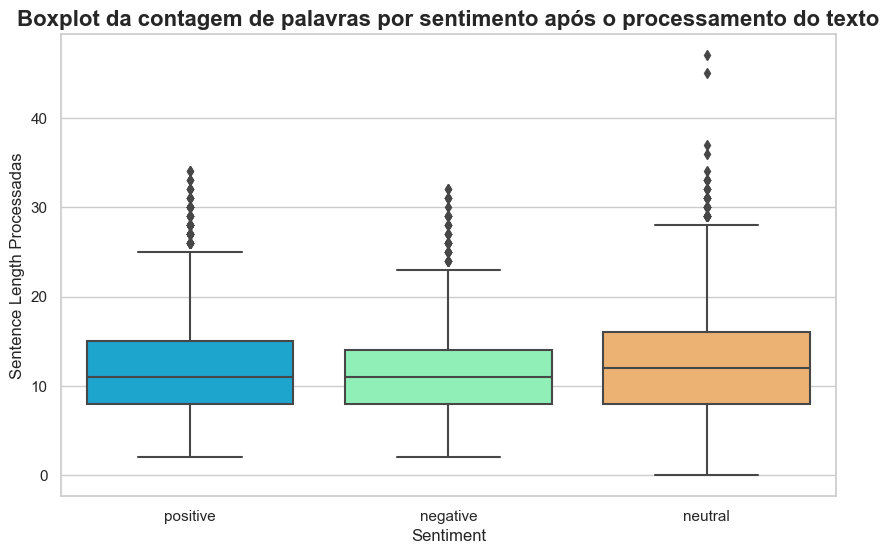

In [152]:
#Criando um Boxplot para a quantidade de palavras por sentimento com o texto tratado.
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.boxplot(x='Sentiment', y='Sentence Length Processadas', data=data, palette="rainbow")
plt.title("Boxplot da contagem de palavras por sentimento após o processamento do texto", fontsize =16,
fontweight= 'bold')
plt.show()


In [153]:
# Exibir as estatísticas descritivas de cada sentença após o processamento do texto.
agr3 = data.groupby('Sentiment')
agr4 = agr3['Sentence Length'].describe()
print(agr4)

            count       mean       std  min   25%   50%   75%   max
Sentiment                                                          
negative    860.0  17.590698  8.944527  2.0  11.0  16.0  23.0  52.0
neutral    3130.0  19.655272  8.795519  1.0  13.0  18.0  25.0  52.0
positive   1852.0  18.089633  9.190085  2.0  11.0  16.0  24.0  50.0


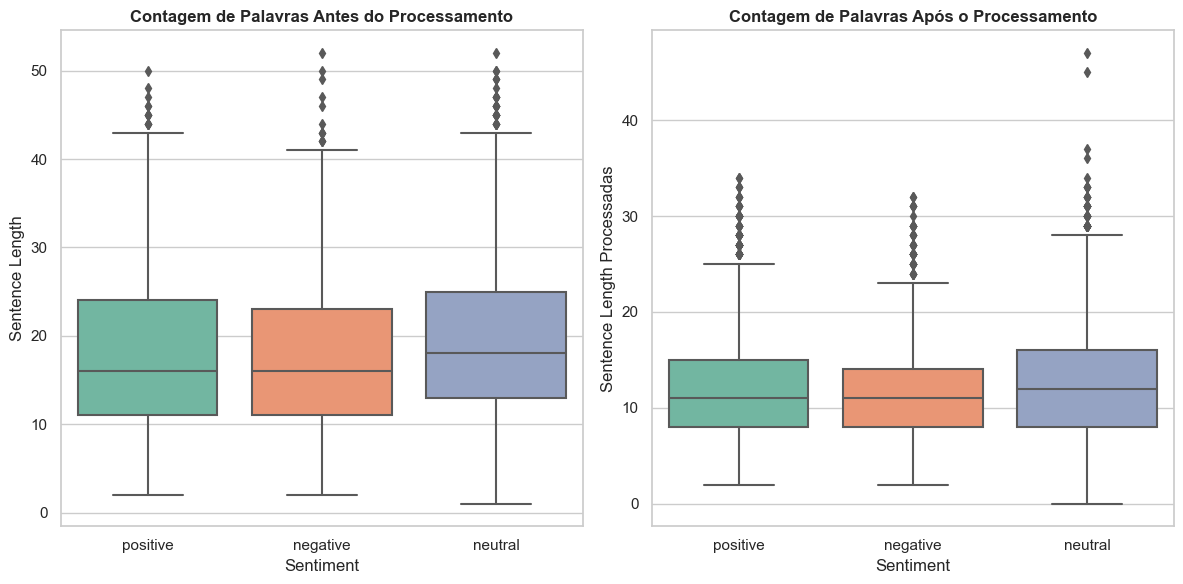

In [154]:
#Criando dois Boxplots para comparação de Pré-Processamento e Pós-Processamento.

#1º Boxplot (Pré-Processamento)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='Sentiment', y='Sentence Length', data=data, palette='Set2')
plt.title('Contagem de Palavras Antes do Processamento', fontsize = 12, fontweight= 'bold')

# Segundo boxplot (Pós-Processamento)
plt.subplot(1, 2, 2)
sns.boxplot(x='Sentiment', y='Sentence Length Processadas', data=data, palette='Set2')
plt.title('Contagem de Palavras Após o Processamento', fontsize = 12, fontweight= 'bold')

plt.tight_layout()
plt.show()

In [155]:
#Comparação estatistica

estatisticas_antes = data.groupby('Sentiment')['Sentence Length'].describe()
estatisticas_depois = data.groupby('Sentiment')['Sentence Length Processadas'].describe()

print("Estatísticas Descritivas Agrupadas por Sentimento Antes do Processamento:")
print(estatisticas_antes)
print("\nEstatísticas Descritivas Agrupadas por Sentimento Após o Processamento:")
print(estatisticas_depois)

Estatísticas Descritivas Agrupadas por Sentimento Antes do Processamento:
            count       mean       std  min   25%   50%   75%   max
Sentiment                                                          
negative    860.0  17.590698  8.944527  2.0  11.0  16.0  23.0  52.0
neutral    3130.0  19.655272  8.795519  1.0  13.0  18.0  25.0  52.0
positive   1852.0  18.089633  9.190085  2.0  11.0  16.0  24.0  50.0

Estatísticas Descritivas Agrupadas por Sentimento Após o Processamento:
            count       mean       std  min  25%   50%   75%   max
Sentiment                                                         
negative    860.0  11.908140  5.828929  2.0  8.0  11.0  14.0  32.0
neutral    3130.0  12.616613  6.159952  0.0  8.0  12.0  16.0  47.0
positive   1852.0  12.184125  6.150736  2.0  8.0  11.0  15.0  34.0


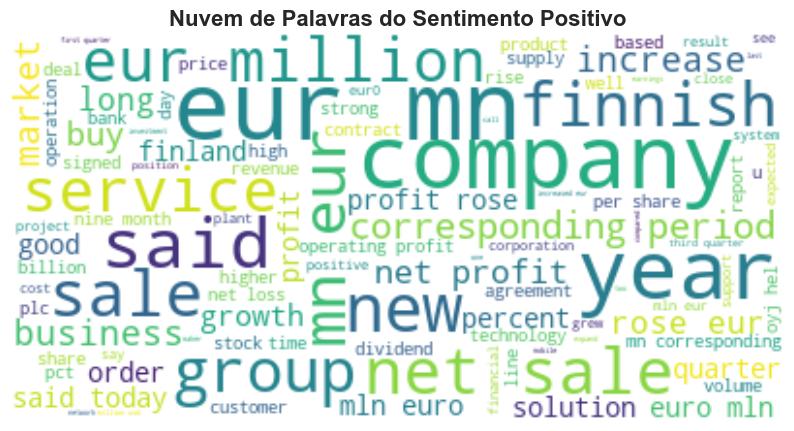

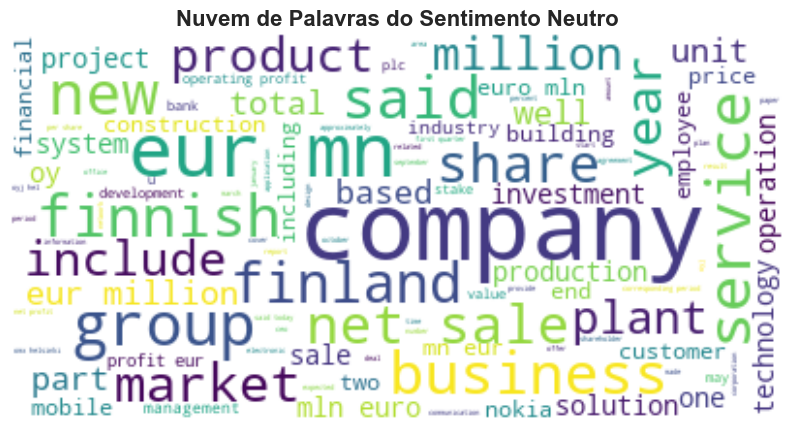

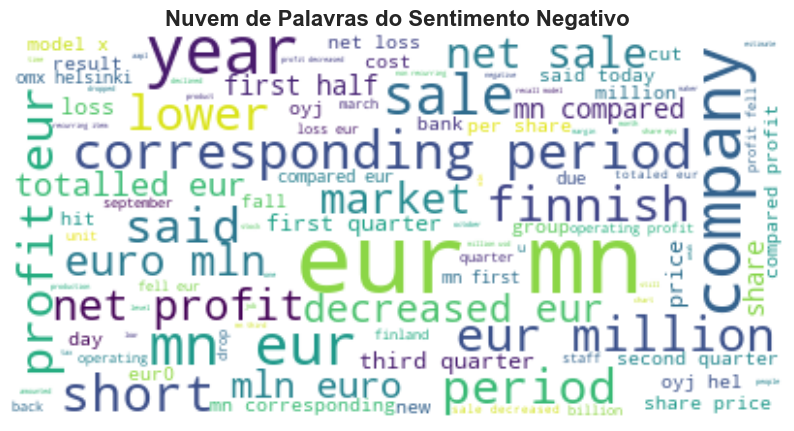

In [156]:
# Criando uma nuvem de palavras para exibir as palavras mais utilizadas em cada categoria de sentimento - Pós-Processamento

textos_positivos = data['Sentences_Processadas'][data['Sentiment'] == 'positive']
textos_neutros = data['Sentences_Processadas'][data['Sentiment'] == 'neutral']
textos_negativos = data['Sentences_Processadas'][data['Sentiment'] == 'negative']

def tokenizador(texto):
    tokens = nltk.word_tokenize(texto)
    return " ".join(tokens)

def nuvem_palavras(texto, etiqueta):
    nuvem = WordCloud(
        background_color='white', 
        max_font_size=50, 
        max_words=100
    )
    nuvem.generate(texto)
    plt.figure(figsize=(10, 8))
    plt.imshow(nuvem, interpolation='bilinear')
    plt.title(f'Nuvem de Palavras do Sentimento {etiqueta}', fontsize=16, fontweight='bold')
    plt.axis('off')

nuvem_palavras(tokenizador(textos_positivos.str.cat()), 'Positivo')
nuvem_palavras(tokenizador(textos_neutros.str.cat()), 'Neutro')
nuvem_palavras(tokenizador(textos_negativos.str.cat()), 'Negativo')
plt.show()

In [157]:
# Excluir as colunas inutilizadas
columns_to_drop = ['Sentence', 'Sentence Length', 'Sentence Length Processadas']
data.drop(columns=columns_to_drop, inplace=True)
# Reorganizar as colunas
new_order = ['Sentences_Processadas', 'Sentiment'] + [col for col in data.columns if col not in ['Sentences_Processadas', 'Sentiment']]
data = data[new_order]

# Exibir o DataFrame com as colunas reorganizadas
display(data)

,Sentences_Processadas,Sentiment
0,geosolutions technology leverage benefon gps s...,positive
1,esi low 150 250 bk real possibility,negative
2,last quarter 2010 componenta net sale doubled ...,positive
3,according finnish-russian chamber commerce maj...,neutral
4,swedish buyout firm sold remaining 224 percent...,neutral
...,...,...
5837,rising cost forced packaging producer huhtamak...,negative
5838,nordic walking first used summer training meth...,neutral
5839,according shipping company viking line eu deci...,neutral
5840,building home improvement trade sale decreased...,neutral


# Modelo

In [158]:
#Transformando os sentimentos em números através do módulo LabelEncoder
le = LabelEncoder()
data['Sentiment'] = le.fit_transform(data['Sentiment'])

In [159]:
display (data)
# 1 = Neutro
# 2 = Positivo
# 0 = Negativo

,Sentences_Processadas,Sentiment
0,geosolutions technology leverage benefon gps s...,2
1,esi low 150 250 bk real possibility,0
2,last quarter 2010 componenta net sale doubled ...,2
3,according finnish-russian chamber commerce maj...,1
4,swedish buyout firm sold remaining 224 percent...,1
...,...,...
5837,rising cost forced packaging producer huhtamak...,0
5838,nordic walking first used summer training meth...,1
5839,according shipping company viking line eu deci...,1
5840,building home improvement trade sale decreased...,1


In [161]:
data['Sentiment'].value_counts()

1    3130
2    1852
0     860
Name: Sentiment, dtype: int64

In [166]:
# Como vimos no código anterior, os sentimentos estão desbalanceados,
#Criando uma amostragem com dados balanceados

df_neutro = data[(data['Sentiment'] == 1)] 
df_negativo = data[(data['Sentiment'] == 0)]
df_positivo = data[(data['Sentiment'] == 2)]

# Upsample classes minoritárias
df_negativo_upsampled = resample(df_negativo, 
                                 replace=True,    
                                 n_samples=3130, 
                                 random_state=42)  

df_positivo_upsampled = resample(df_positivo, 
                                 replace=True,    
                                 n_samples=3130, 
                                 random_state=42)  

# Concatenar os dataframes upsamplados com o dataframe neutro
dados_finais = pd.concat([df_negativo_upsampled, df_neutro, df_positivo_upsampled])


In [168]:
#Criando os parâmetros do Vetor

# Número máximo de palavras a serem utilizadas (mais frequentes).
MAX_NB_WORDS = 50000

# Número máximo de palavras em cada sequência.
MAX_SEQUENCE_LENGTH = 250

# Dimensão dos vetores de incorporação.

EMBEDDING_DIM = 100


In [178]:
#Processamdo o texto.
#Removendo pontuação e espaços, tokenizando, criandi índices às palavras
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(dados_finais['Sentences_Processadas'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


Found 10543 unique tokens.


In [182]:
# Convertendo textos em sequências de números usando o tokenizer

X_final = tokenizer.texts_to_sequences(dados_finais['Sentences_Processadas'].values)

# Preenchendo (padding) as sequências para ter o mesmo comprimento

X_final = pad_sequences(X_final, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_final.shape)

Shape of data tensor: (9390, 250)


In [184]:
# Criando variáveis dummy (one-hot encoding) para os rótulos de sentimentos
Y_final = pd.get_dummies(dados_finais['Sentiment']).values

# Imprimindo a forma do tensor de rótulos
print('Rótulo', Y_final.shape)

Rótulo (9390, 3)


### Dividindo entre treino e teste

In [185]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_final, Y_final, test_size = 0.3, random_state = 42, shuffle=True)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(6573, 250) (6573, 3)
(2817, 250) (2817, 3)


### Treinando o Modelo GRU

In [187]:
# Criando um modelo de rede neural sequencial 
gru_model = Sequential()

# Adicionando uma camada de incorporação (embedding) para representar palavras como vetores
gru_model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_final.shape[1]))

# Adicionando uma camada de Dropout espacial para prevenir overfitting
gru_model.add(SpatialDropout1D(0.2))

# Adicionando uma camada GRU (Gated Recurrent Unit) para processar sequências temporais
gru_model.add(GRU(128, dropout=0.2, recurrent_dropout=0.2))

# Adicionando uma camada densa (fully connected) com ativação softmax para a saída
gru_model.add(Dense(3, activation='softmax'))

# Compilando o modelo usando categorical crossentropy como função de perda
# e otimizador Adam para ajustar os pesos da rede
gru_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Definindo o número de épocas e o tamanho do lote para treinamento
epochs = 5
batch_size = 64

# Treinando o modelo no conjunto de treinamento com validação em uma parte dos dados
gru_history = gru_model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)


Epoch 1/5
83/83 [==============================] - 100s 1s/step - loss: 0.9973 - accuracy: 0.5164 - val_loss: 0.8134 - val_accuracy: 0.5947
Epoch 2/5
83/83 [==============================] - 88s 1s/step - loss: 0.5248 - accuracy: 0.7980 - val_loss: 0.5980 - val_accuracy: 0.7749
Epoch 3/5
83/83 [==============================] - 87s 1s/step - loss: 0.2873 - accuracy: 0.8944 - val_loss: 0.6113 - val_accuracy: 0.7901
Epoch 4/5
83/83 [==============================] - 90s 1s/step - loss: 0.2035 - accuracy: 0.9190 - val_loss: 0.6200 - val_accuracy: 0.8152
Epoch 5/5
83/83 [==============================] - 90s 1s/step - loss: 0.1667 - accuracy: 0.9312 - val_loss: 0.6527 - val_accuracy: 0.8046


### Avaliação do Modelo

In [188]:
gru_accuracy = gru_model.evaluate(X_test,Y_test)
print('GRU Model Evaluation\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(gru_accuracy[0],gru_accuracy[1]))

89/89 [==============================] - 5s 52ms/step - loss: 0.6514 - accuracy: 0.8016
GRU Model Evaluation
 Loss: 0.651
 Accuracy: 0.802


In [208]:
# Exemplo de pré-processamento para uma única sentença do usuário
entrada_usuario = "According to G1, Lojas Americanas sales fall after discovery of billion-dollar debt"

#Texto em português 'Segundo G1, as vendas das Lojas Americanas caem após descoberta de dívida bilionária.'


sequencia_usuario = tokenizer.texts_to_sequences([entrada_usuario])
sequencia_usuario_padronizada = pad_sequences(sequencia_usuario, maxlen=COMPRIMENTO_MAX_SEQ)

# Predição usando o modelo treinado
previsao = gru_model.predict(sequencia_usuario_padronizada)

# Convertendo a saída da previsão para a classe predita
classe_predita = np.argmax(previsao)

# Imprimindo a classe predita
print("Sentimento Predito:", classe_predita)

# 1 = Neutro
# 2 = Positivo
# 0 = Negativo

1/1 [==============================] - 0s 39ms/step
Sentimento Predito: 0
